In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv # cleaned Stanford dataset

--2022-03-29 03:34:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.251.16.128, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   108MB/s    in 2.1s    

2022-03-29 03:34:48 (108 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
import pandas as pd
dataDF = pd.read_csv('/tmp/training_cleaned.csv',names=['a','b','c','d','e','f'])

In [ ]:
dataDF

a           b                             c         d  \
0        0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1        0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2        0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3        0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4        0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...     ..         ...                           ...       ...   
1599995  4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996  4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997  4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998  4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999  4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                       e                                                  f  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1          scotthamilton  is upset that he can't update his Facebook by ...  
2               mattycus  @Kenichan I dived many times for the ball. Man...  
3                ElleCTF    my whole body feels itchy and like its on fire   
4                 Karoli  @nationwideclass no, it's not behaving at all....  
...                  ...                                                ...  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...  

[1600000 rows x 6 columns]

In [ ]:
num_sentences = 0
corpus = [] 
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item = []
        list_item.append(row[5])
        this_label = row[0]
        if this_label == '0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [ ]:
corpus

[["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
  0],
 ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
  0],
 ['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
  0],
 ['my whole body feels itchy and like its on fire ', 0],
 ["@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
  0],
 ['@Kwesidei not the whole crew ', 0],
 ['Need a hug ', 0],
 ["@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
  0],
 ["@Tatiana_K nope they didn't have it ", 0],
 ['@twittera que me muera ? ', 0],
 ["spring break in plain city... it's snowing ", 0],
 ['I just re-pierced my ears ', 0],
 ["@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
  0],
 ['@octolinz16 It it c

In [ ]:
len(corpus)

1600000

In [ ]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000
test_portion=.1

In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [ ]:
sentences

["@Annie_Lang He'll prob just go himself, he's trying to sell them to get a bit o moola!  xx",
 'i only have a dollar left  i usewd $2 on massage chairs',
 'getting ready for work... ',
 '@foxtrotonline Not good. ',
 '@shoptilldrop why thank you, young lady for the #followfriday mention. ',
 'radio play in Germany, Midlands UK and Virginia USA this week  ',
 '@SyrDylan Ciao,how are you romantic man? ',
 "omg u guys rool. now i'm at 683 ",
 'is tired, and think I failed my test yesterday ',
 'Well this has ruined my picnic with megan ',
 "It won't be easy, but it will be good, it will conquer all above, and it shall walk tall and be in wonder of how he chose so divinely . ",
 'would very much like to be at Glasto ',
 'Lazy Friday. Cuddled on the couch watching le tele. Perfection. ',
 'at least that one was polite ',
 "Stuck in a situation and doesn't know how to get out  I guess I was meant to grow up this way.",
 'Off now watching TV!! ',
 '@SweetMizery22 they only keep for about 2 da

In [ ]:
labels

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
vocab_size

138409

In [ ]:
print(word_index)

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'is': 8, 'it': 9, 'in': 10, 'for': 11, 'of': 12, 'on': 13, 'me': 14, 'so': 15, 'have': 16, 'that': 17, 'but': 18, "i'm": 19, 'just': 20, 'with': 21, 'be': 22, 'at': 23, 'not': 24, 'was': 25, 'now': 26, 'this': 27, 'good': 28, 'up': 29, 'day': 30, 'all': 31, 'out': 32, 'get': 33, 'like': 34, 'are': 35, 'no': 36, 'go': 37, 'quot': 38, 'http': 39, "it's": 40, 'today': 41, 'do': 42, 'too': 43, 'your': 44, 'going': 45, 'love': 46, 'work': 47, 'got': 48, 'lol': 49, 'back': 50, 'time': 51, 'from': 52, 'u': 53, 'what': 54, 'im': 55, 'com': 56, 'will': 57, 'one': 58, 'am': 59, 'we': 60, 'know': 61, "don't": 62, 'about': 63, 'really': 64, 'amp': 65, 'had': 66, 'can': 67, 'some': 68, 'see': 69, "can't": 70, 'its': 71, 'if': 72, 'still': 73, '2': 74, 'new': 75, 'night': 76, 'want': 77, 'well': 78, 'thanks': 79, 'how': 80, 'think': 81, 'there': 82, 'when': 83, 'home': 84, 'oh': 85, 'as': 86, 'here': 87, 'off': 88, 'last': 89, 'much': 

In [ ]:
padded

array([[  5907,   3292,   1938, ...,     33,      4,    128],
       [     1,    116,     16, ...,      0,      0,      0],
       [   131,    208,     11, ...,      0,      0,      0],
       ...,
       [   119,   1913,     30, ...,      0,      0,      0],
       [138407, 138408,    248, ...,      0,      0,      0],
       [  3547,     15, 138409, ...,     28,      0,      0]], dtype=int32)

In [ ]:
padded.shape

(160000, 16)

In [ ]:
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [ ]:
test_sequences.shape

(16000, 16)

In [ ]:
training_sequences.shape

(144000, 16)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-29 03:51:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-29 03:51:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-29 03:51:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
embeddings_index.keys()

dict_keys(['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.', 'so', 'them', 'what', 'him', 'united', 'during', 'before', 'may', 'since', 'many', 'while', 'where', 'states', 'because', 'now', 'city', 'made', 'like', 'between', 'did', 'just', 'national', 'day', 'country', 'under', 'such', 'second', 'then', 'company', 'group

In [ ]:
word_index

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'and': 6,
 'you': 7,
 'is': 8,
 'it': 9,
 'in': 10,
 'for': 11,
 'of': 12,
 'on': 13,
 'me': 14,
 'so': 15,
 'have': 16,
 'that': 17,
 'but': 18,
 "i'm": 19,
 'just': 20,
 'with': 21,
 'be': 22,
 'at': 23,
 'not': 24,
 'was': 25,
 'now': 26,
 'this': 27,
 'good': 28,
 'up': 29,
 'day': 30,
 'all': 31,
 'out': 32,
 'get': 33,
 'like': 34,
 'are': 35,
 'no': 36,
 'go': 37,
 'quot': 38,
 'http': 39,
 "it's": 40,
 'today': 41,
 'do': 42,
 'too': 43,
 'your': 44,
 'going': 45,
 'love': 46,
 'work': 47,
 'got': 48,
 'lol': 49,
 'back': 50,
 'time': 51,
 'from': 52,
 'u': 53,
 'what': 54,
 'im': 55,
 'com': 56,
 'will': 57,
 'one': 58,
 'am': 59,
 'we': 60,
 'know': 61,
 "don't": 62,
 'about': 63,
 'really': 64,
 'amp': 65,
 'had': 66,
 'can': 67,
 'some': 68,
 'see': 69,
 "can't": 70,
 'its': 71,
 'if': 72,
 'still': 73,
 '2': 74,
 'new': 75,
 'night': 76,
 'want': 77,
 'well': 78,
 'thanks': 79,
 'how': 80,
 'think': 81,
 'there': 82,
 'when

In [ ]:
len(embeddings_index.keys())

400000

In [ ]:
embeddings_matrix.shape

(138410, 100)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)
num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

Epoch 1/50
4500/4500 [==============================] - 24s 3ms/step - loss: 0.5725 - accuracy: 0.6958 - val_loss: 0.5360 - val_accuracy: 0.7271
Epoch 2/50
4500/4500 [==============================] - 13s 3ms/step - loss: 0.5344 - accuracy: 0.7265 - val_loss: 0.5240 - val_accuracy: 0.7352
Epoch 3/50
4500/4500 [==============================] - 13s 3ms/step - loss: 0.5186 - accuracy: 0.7383 - val_loss: 0.5174 - val_accuracy: 0.7446
Epoch 4/50
4500/4500 [==============================] - 12s 3ms/step - loss: 0.5086 - accuracy: 0.7446 - val_loss: 0.5173 - val_accuracy: 0.7405
Epoch 5/50
4500/4500 [==============================] - 13s 3ms/step - loss: 0.5022 - accuracy: 0.7500 - val_loss: 0.5128 - val_accuracy: 0.7426
Epoch 6/50
4500/4500 [==============================] - 13s 3ms/step - loss: 0.4948 - accuracy: 0.7540 - val_loss: 0.5110 - val_accuracy: 0.7442
Epoch 7/50
4500/4500 [==============================] - 12s 3ms/step - loss: 0.4913 - accuracy: 0.7577 - val_loss: 0.5097 - val_ac

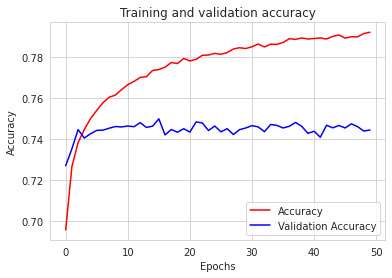

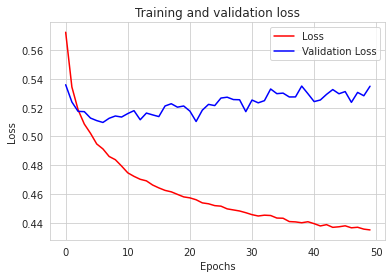

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()
# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
